# The California housing problem

The goal is to predict the median house value on a series of California districts.

Read info on the problem and download csv file from https://www.kaggle.com/camnugent/california-housing-prices.

### Instrucciones de entrega

#### Seguid cuidadosamente las siguientes pautas

1. Crear un directorio de nombre vuestro apellido.
2. Situar en él 
    * Un archivo `apellido_afi_2018.ipynb` con vuestro notebook completo y otro archivo `apellido_afi_2018.html` con una versión html
    * Un archivo `cal_housing.csv` con los datos del problema.
    * Un archivo `'mlp_alpha_search_results.pkl` con los resultados de GridSearchCV para vuestro MLP.
    * Un archivo `'svr_C_gamma_epsilon_cv_search_results.pkl` con los resultados de GridSearchCV para vuestra SVR.
3. Situar también en él un archivo word `apellido.docx`  o pdf `apellido.pdf` con las respuestas al cuestionario.
4. Comprimir el **directorio** a un archivo `apellido.zip` o `apellido.7z` que será lo que se entregue

Para cualquier duda,consultar con el profesor (jose.dorronsoro@uam.es) 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#put all your imports here
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import time
import pickle
import gzip
#import seaborn as sns

## Data Preprocessing

**_After loading data apply the following steps_**

* Check data counts and remove possible missing values using Pandas' `dropna` method.
* Ignore the longitude and latitude variables and also the categorical variable `ocean_proximity`.
* Analyze the original variables and consider new variables which could be more informative.
* Analyze feature distributions and adequately remove possible outliers.

In [3]:
f = 'cal_housing.csv'

df_housing_raw = pd.read_csv(f)

print ("n_rows: %d\tn_columns: %d\n" % (df_housing_raw.shape[0], df_housing_raw.shape[1]) )
print ("columns:\t", list(df_housing_raw.columns))

n_rows: 20640	n_columns: 10

columns:	 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


** The Exploratory Analisys of the Data **

**Let's get some basic informaction about the data:**

In [4]:
df_housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**_Check the data counts and if needed, remove the records with possibly missing values.
You can use the dropna method in pandas for this._**

*Removing the NA's *

In [5]:
df_housing_raw.dropna(inplace=True)

*The statistical*

In [6]:
df_housing_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20433.0,-119.570689,2.003578,-124.3500,-121.8000,-118.4900,-118.010,-114.3100
latitude,20433.0,35.633221,2.136348,32.5400,33.9300,34.2600,37.720,41.9500
housing_median_age,20433.0,28.633094,12.591805,1.0000,18.0000,29.0000,37.000,52.0000
total_rooms,20433.0,2636.504233,2185.269567,2.0000,1450.0000,2127.0000,3143.000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.000,6445.0000
population,20433.0,1424.946949,1133.208490,3.0000,787.0000,1166.0000,1722.000,35682.0000
households,20433.0,499.433465,382.299226,1.0000,280.0000,409.0000,604.000,6082.0000
median_income,20433.0,3.871162,1.899291,0.4999,2.5637,3.5365,4.744,15.0001
median_house_value,20433.0,206864.413155,115435.667099,14999.0000,119500.0000,179700.0000,264700.000,500001.0000


In [7]:
df_housing_raw.shape

(20433, 10)

In [8]:
print(df_housing_raw.isnull().any().sum(), ' / ', len(df_housing_raw.columns))

print(df_housing_raw.isnull().any(axis=1).sum(), ' / ', len(df_housing_raw))

0  /  10
0  /  20433


Working variables:

For simplicity we will not consider the longitude and latitude variables. We will also ignore the categoric variable `ocean_proximity`although it might encode useful house value information.

In [9]:
vars1     = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
target   = ['median_house_value']

**_The initial variables may not be too useful as some of them (e.g., `total_rooms`) represent total values over a district. It seems thus sensible to use as new (or extra) variables their averages per household._**

**_Decide which variables should be thus treated and which shouldn't, compute the new variables you think useful_**

**_Explain HERE clearly why you choose the new variables_**

 * We will create a new variable called *rooms_per_household* as a fraction of *total_rooms* divide by *househols*

In [10]:
df_housing_raw["rooms_per_household"] = df_housing_raw["total_rooms"] / df_housing_raw["households"]


 * We will create a new variable  to get the bedrooms per rooms this variablis will tell us how many bedrooms has the house per rooms

In [11]:
df_housing_raw["bedrooms_per_room"] = df_housing_raw["total_bedrooms"] / df_housing_raw["total_rooms"]


 * Finally let´s get to create the variable *population_per _houselhold* in order to know how many people are in the 
neighborhood

In [12]:
df_housing_raw["population_per_household"] =df_housing_raw["population"] / df_housing_raw["households"]

**_Analyze the new data looking for extreme values and, finally, drop those patterns for which some of these variables may have values that you think unlikely._**

**_Explain HERE clearly which values you consider too high and how you are to what transform the initial data_**

Let's plot the histogram of each variable

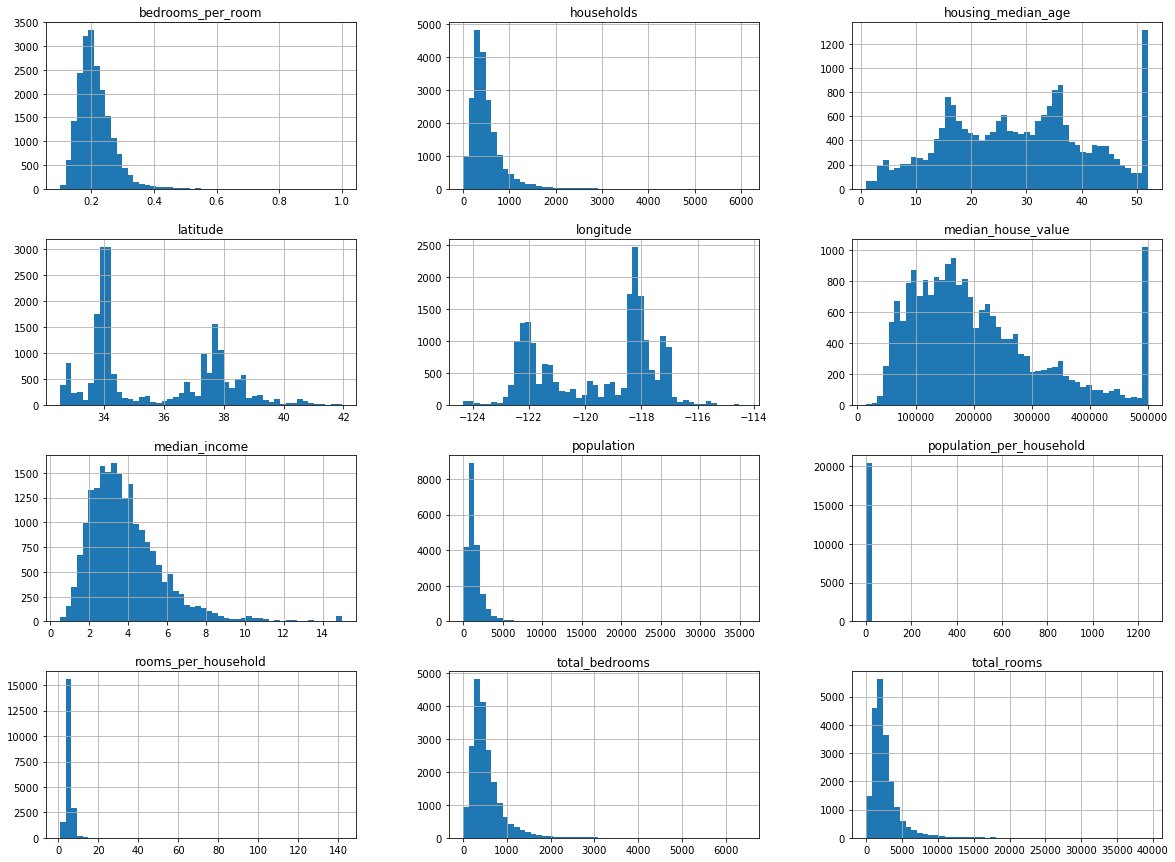

In [13]:

df_housing_raw.hist(bins=50, figsize=(20,15))
plt.show()

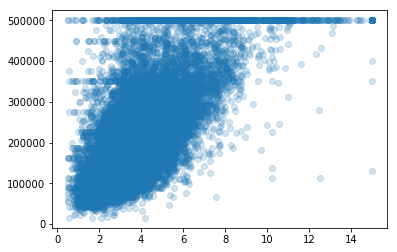

In [14]:
import matplotlib.pyplot as plt
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.text import Text
from matplotlib.image import AxesImage
import numpy as np
from numpy.random import rand
#%matplotlib notebook
def onclick(event):
    ind = event.ind
    print('onpick3 scatter:', ind, np.take(x, ind), np.take(y, ind))


fig,ax = plt.subplots()
col= ax.scatter(x=df_housing_raw[df_housing_raw.median_house_value!=270000]['median_income'],y=df_housing_raw[df_housing_raw.median_house_value!=270000]['median_house_value'], picker= 10, alpha=0.2)
fig.canvas.mpl_connect('pick_event', onclick)
plt.show()

**As we can see in the histogram and in the scatterplot the housing median age vs the median house value were capped, and we need to delete that observations in order to have a clean data. we noticed as the price
cap is clearly visible as a horizontal line at  \$500,000. But this plot reveals other less obvious straight lines: a horizontal line around \$450,000, \$275000 and so on.**

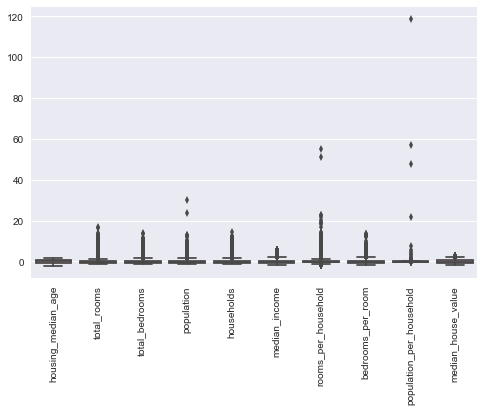

In [15]:
#normalizamos para tener rangos uniformes en histogramas
import seaborn as sns
df_housing_select = df_housing_raw[vars1+ ['rooms_per_household', 'bedrooms_per_room','population_per_household' ]+
                                   target]

df_housing_normalized = (df_housing_select - df_housing_select.mean()) / df_housing_select.std() 

plt.figure( figsize=(8, 5))
#sns.set_style("white")
bx_plot = sns.boxplot(data=df_housing_normalized)
#bx_plot = sns.boxplot(data=df_housing)
plt.xticks(rotation=90)
plt.show()

In [16]:
df_housing_select.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,median_house_value
0,41.0,880.0,129.0,322.0,126.0,8.3252,6.984127,0.146591,2.555556,452600.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,6.238137,0.155797,2.109842,358500.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,8.288136,0.129516,2.802260,352100.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,5.817352,0.184458,2.547945,341300.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,6.281853,0.172096,2.181467,342200.0


### Let's  make some regression plots in order to see the influence of outliers

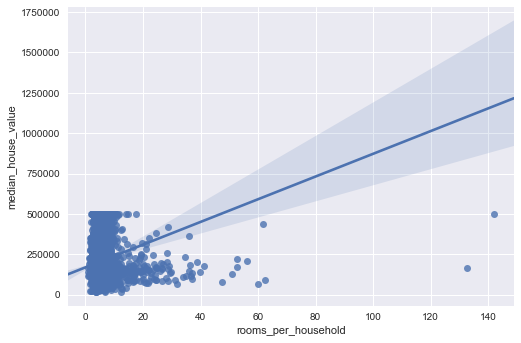

In [17]:
sns.regplot(x=df_housing_select['rooms_per_household'],y=df_housing_select['median_house_value'])
plt.show()

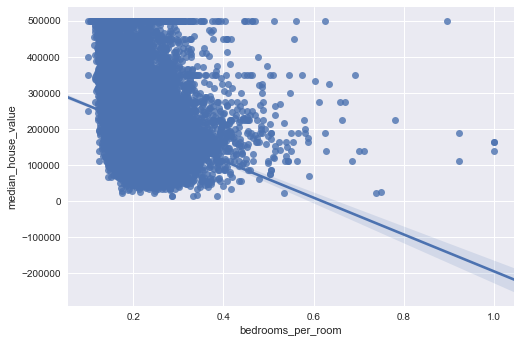

In [18]:
sns.regplot(x=df_housing_select['bedrooms_per_room'],y=df_housing_select['median_house_value'])
plt.show()

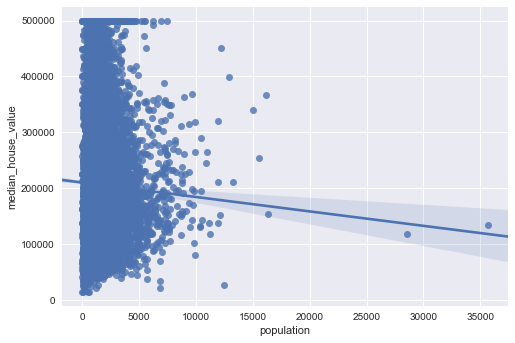

In [19]:
sns.regplot(x=df_housing_select['population'],y=df_housing_select['median_house_value'])
plt.show()

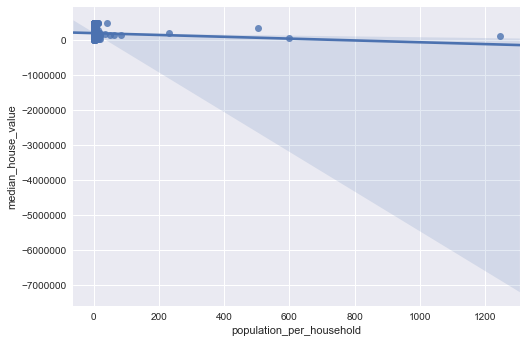

In [20]:
sns.regplot(x=df_housing_select['population_per_household'],y=df_housing_select['median_house_value'])
plt.show()

In [21]:
df_housing_select.describe().T

,count,mean,std,min,25%,50%,75%,max
housing_median_age,20433.0,28.633094,12.591805,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,20433.0,2636.504233,2185.269567,2.000000,1450.000000,2127.000000,3143.000000,39320.000000
total_bedrooms,20433.0,537.870553,421.385070,1.000000,296.000000,435.000000,647.000000,6445.000000
population,20433.0,1424.946949,1133.208490,3.000000,787.000000,1166.000000,1722.000000,35682.000000
households,20433.0,499.433465,382.299226,1.000000,280.000000,409.000000,604.000000,6082.000000
median_income,20433.0,3.871162,1.899291,0.499900,2.563700,3.536500,4.744000,15.000100
rooms_per_household,20433.0,5.431344,2.482946,0.846154,4.441441,5.230769,6.052381,141.909091
bedrooms_per_room,20433.0,0.213039,0.057983,0.100000,0.175427,0.203162,0.239821,1.000000
population_per_household,20433.0,3.071533,10.438269,0.692308,2.429032,2.817582,3.281513,1243.333333
median_house_value,20433.0,206864.413155,115435.667099,14999.000000,119500.000000,179700.000000,264700.000000,500001.000000


### Drop the outliers observations  over the mean plus/minus three standard deviations

In [22]:
from scipy import stats
df_housing_select = df_housing_select[(np.abs(stats.zscore(df_housing_select)) < 3).all(axis=1)]

In [23]:
df_housing_select = df_housing_select.drop(df_housing_select[(df_housing_select.rooms_per_household>=35) | (df_housing_select.population >= 12000)  ].index)

### Drop observations with *housing_median_value* greater than 500000, because these values were capped

In [24]:
df_housing_select = df_housing_select.drop(df_housing_select[(df_housing_select.median_house_value>=500000)  ].index)

In [25]:
df_housing_select = df_housing_select.drop(df_housing_select[(df_housing_select.median_house_value==450000)  ].index)
df_housing_select = df_housing_select.drop(df_housing_select[(df_housing_select.median_house_value==350000)  ].index)
df_housing_select = df_housing_select.drop(df_housing_select[(df_housing_select.median_house_value==275000)  ].index)
df_housing_select = df_housing_select.drop(df_housing_select[(df_housing_select.median_house_value==225000)  ].index)
df_housing_select = df_housing_select.drop(df_housing_select[(df_housing_select.median_house_value==162500)  ].index)
df_housing_select = df_housing_select.drop(df_housing_select[(df_housing_select.median_house_value==137500)  ].index)
df_housing_select = df_housing_select.drop(df_housing_select[(df_housing_select.population_per_household>=10)  ].index)


In [26]:
df_housing_select.shape

(18061, 10)

Finally we have 18061 observations

**_After these operations have been done, write HERE a descriptive analysis of your data, considering whether you could drop some features to alleviate computational costs. 

We decide to drop the vars *"total_rooms", "total_bedrooms", "households", "population", "housing_median_age", "rooms_per_household"*

In [27]:
df_housing_select.drop([ "total_rooms", "total_bedrooms", "households", "population", "housing_median_age", "rooms_per_household"], axis=1, inplace=True)

In [28]:
df_housing_select.describe().T

,count,mean,std,min,25%,50%,75%,max
median_income,18061.0,3.680477,1.511903,0.499900,2.553600,3.475000,4.590900,9.556100
bedrooms_per_room,18061.0,0.210929,0.046342,0.100000,0.177497,0.203616,0.237873,0.386709
population_per_household,18061.0,2.944271,0.747904,1.060606,2.455830,2.840367,3.301653,9.954545
median_house_value,18061.0,190343.945296,96737.296050,14999.000000,113900.000000,172900.000000,246000.000000,499100.000000


## Correlation Analysis

In [29]:
corr_matrix = df_housing_select.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.671128
population_per_household   -0.251629
bedrooms_per_room          -0.279503
Name: median_house_value, dtype: float64

From correlations we can see as the median house value tends to go
up when the median income goes up(positive correlation). When the coefficient is close to –1 or negative, it means
that there is a negative correlation; we can see a small negative correlation 
between the population_per_household and the bedrooms_per_room   

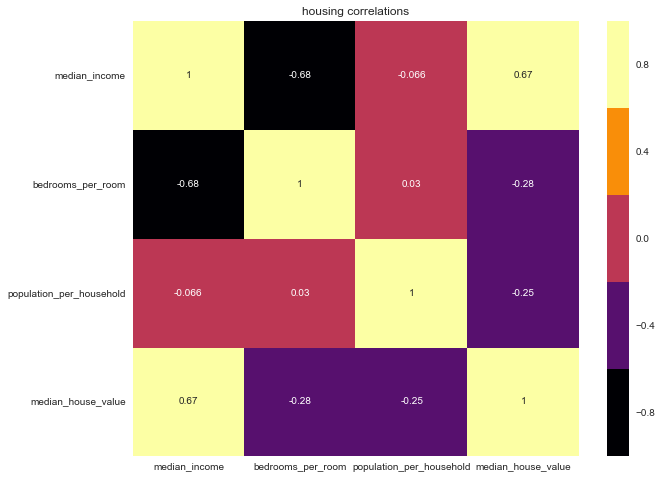

In [30]:
# correlation heatmap
%matplotlib inline
cMap = plt.cm.get_cmap("inferno",lut=5) 

plt.figure( figsize=(10, 8))
plt.title('housing correlations')
_ = sns.heatmap(df_housing_select.corr().values, vmin=-1., vmax=1., cmap=cMap, annot=True,
                xticklabels=list(df_housing_select.columns),
                yticklabels=list(df_housing_select.columns))

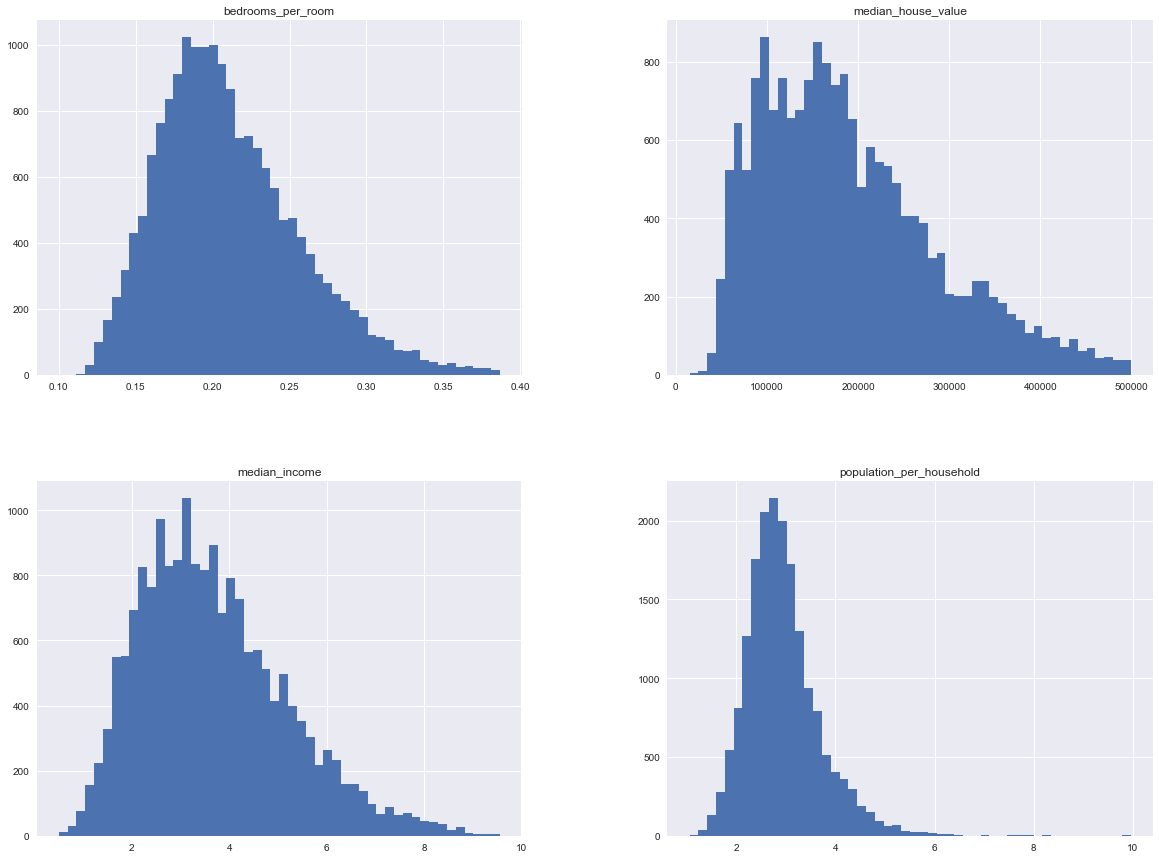

In [31]:

df_housing_select.hist(bins=50, figsize=(20,15))
plt.show()

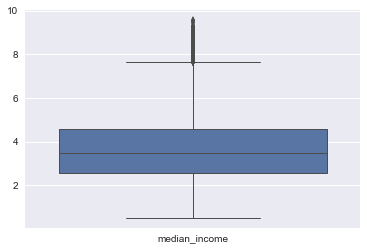

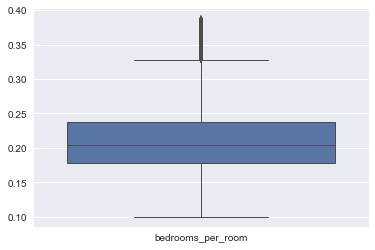

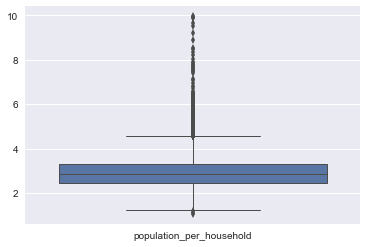

In [32]:
names = df_housing_select.loc[:,  df_housing_select.columns!="median_house_value"].columns
for name in names:
    ax=sns.boxplot( data=df_housing_select[[name]], linewidth=1)
    plt.show()

**_Write HERE your conclusions on the data._**

The median house value has some weird cap applied to it causing there to be a blip at the rightmost point on the hist, we must removed the cap values, also we notice that is there only few correlations between the var to predict  and the predictions variable, also in our data we had considered outliers the observations far away from the mean plus/less 3 times standard deviation, finaly some distributions are skewed to the left.

### Downsizing the sample

Before building our models, notice that the sample size is possibly too high for laptop computations.
Because of this we are going to retain only 5000 patterns that we select as follows

1. Generate using numpy a permutation of the numerical indices of the sample.
2. Retain the first 5000 indices in the permutation.
3. Form the final sample dataframe with these 5000 indices.

Of these we will retain the last 1000 as a test set and the first 4000 for training and validation purposes.

Notice also that target values are given in dollars so some values are quite high. We thus scale them to, say, thousands of dollars dividing the target variable by 1000 in order to have smaller targets and errors.

Generate the Index:

In [33]:
from numpy.random import permutation
np.random.seed(10)
index1 = permutation(len(df_housing_select))
index2 = index1[:5000]

Select only 5000 observations

In [34]:
df_housing_select = df_housing_select.iloc[index2]

In [35]:
df_housing_select.columns

Index(['median_income', 'bedrooms_per_room', 'population_per_household',
       'median_house_value'],
      dtype='object')

In [36]:
df_housing_select.shape

(5000, 4)

## MLP models

### Building the train and test datasets

To make sure that the train and the test is a true representacion of the data, we will select the observations based on **StratifiedShuffleSplit**  based on The variable **median_income**, in order to avoid the risk of introducing a significant sampling bias.

In [37]:
df_housing_select["income_cat"] = np.ceil(df_housing_select["median_income"] / 1.5)
df_housing_select["income_cat"].where(df_housing_select["income_cat"] < 5, 5.0, inplace=True)


Let's check the distribution of income_cat:

In [38]:
 df_housing_select["income_cat"].value_counts() / len(df_housing_select)

3.0    0.3694
2.0    0.3338
4.0    0.1782
5.0    0.0864
1.0    0.0322
Name: income_cat, dtype: float64

In [39]:
df_housing_select.reset_index(drop=True, inplace=True)

Now we split in train(4000) and test (1000) our data 

In [40]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
for train_index, test_index in split.split(df_housing_select,df_housing_select["income_cat"]):
    train_set = df_housing_select.loc[train_index]
    test_set = df_housing_select.loc[test_index]


The Distribution on train of the **income_cat** variable:

In [41]:
train_set["income_cat"].value_counts() / len(train_set)

3.0    0.36925
2.0    0.33375
4.0    0.17825
5.0    0.08650
1.0    0.03225
Name: income_cat, dtype: float64

on Test:

In [42]:
test_set["income_cat"].value_counts() / len(test_set)

3.0    0.370
2.0    0.334
4.0    0.178
5.0    0.086
1.0    0.032
Name: income_cat, dtype: float64

Finally, delete the **income_cat** of our data:

In [43]:
for set in (train_set, test_set):
    set.drop(["income_cat"], axis=1, inplace=True)


In [44]:
X_train = train_set[train_set.columns.difference(['median_house_value'])]
X_test = test_set[train_set.columns.difference(['median_house_value'])]
y_train = train_set['median_house_value']
y_test = test_set['median_house_value']

In [45]:
y_train = y_train/1000.0
y_test  = y_test/1000.0

### MLP architecture

Consider first what could be a reasonable number of layers and of units for a MLP. 
Before starting CV, train individual MLPs likely to overfit mesauring times to get a handle on the tolerance to be used. 

**_Write HERE your analysis and architecture and parameter and solver choices_**

In [46]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()
x_train = std_sc.fit_transform( X_train)



We propose an MLP of 2 layers, 17 neurons each:

In [47]:
hidden_layer_sizes = (17, 17)
alpha = 1.e-2

#solver: lbfgs para problemas pequeños, adam para problemas grandes
mlp_m =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                      activation='relu', 
                      solver='lbfgs', alpha=alpha,
                      early_stopping=True,
                      tol=1.e-8, max_iter=10000)
t_0 = time.time()
mlp_m.fit(x_train, y_train)
print("\nmlp_grid_search_time:", time.time() - t_0, "\n\n")


mlp_grid_search_time: 17.47681999206543 




### CV estimation of `alpha`

A reasonable idea is to work with validation sets with more or less the same size than the test set. To do so, use the sklearn `ShuffleSplit` method to work with 5 folds with train-validation splits with sizes 3000-1000.

Decide also on a proper range of $\alpha$ to be explored.

**_Write HERE your CV parameter choices_**

In [48]:
# writhe the code to perform GridSearchCV and to save the CV results in a pkl file 
#            but 
# COMMENT OUT THE GRID SEARCH FIT CALL AND THE PKL FILE SAVING

# use the names of the GridSearchCV object and of the pickle file shown below
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=10)
l_alpha = [10.**k for k in range(-4, 5)]
hidden_layer_sizes = (17, 17)
param_grid = {'alpha': l_alpha}
mlp_m =  MLPRegressor( 
                      hidden_layer_sizes= hidden_layer_sizes,
                      activation='relu', 
                      solver='lbfgs', 
                      early_stopping=True,
                      tol=1.e-6, max_iter=10000)

mlp_alpha_search = GridSearchCV(mlp_m, param_grid=param_grid, cv=cv, 
                                scoring='neg_mean_absolute_error',
                                refit=False,
                                n_jobs=4, verbose=10)

t_0 = time.time()
mlp_alpha_search.fit(x_train, y_train)
print("\nmlp_grid_search_time:", time.time() - t_0, "\n\n")


#mlp_alpha_search.fit(x_train, y_train.ravel())
        
f = open('mlp_alpha_search_results.pkl', mode='wb')
pickle.dump(mlp_alpha_search, f)
f.close()

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   48.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed:  4.4min remaining:   12.2s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  4.4min finished



mlp_grid_search_time: 267.20785880088806 




### Analysis of CV results

**_Recover grid search from pickle file and analyze best parameters_**

best_alpha = 1000.00
best_cv_mae = 45.846


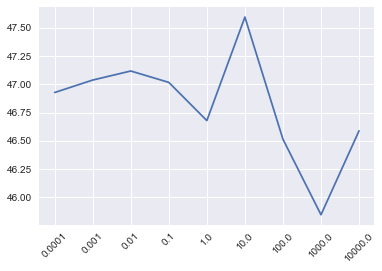

In [49]:
f = open('mlp_alpha_search_results.pkl', mode='rb')
mlp_alpha_search = pickle.load(f)
f.close()

best_alpha = mlp_alpha_search.best_params_['alpha']

print('best_alpha = %.2f' % (best_alpha))
print('best_cv_mae = %.3f' % (-mlp_alpha_search.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -mlp_alpha_search.cv_results_['mean_test_score'])

In [50]:
mlp_alpha_search

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=10, test_size=0.25, train_size=None),
       error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(17, 17), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=1e-06, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=10)

**_Discuss here the adequacy of your CV results_**

The results obtained is an alpha of 1000, no too big this parameters help us to combact overfitting by constraining the size of the weights. in other words this value of alpha may fix high variance by encouraging smaller weights.

### Analysis of Best MLP 

Train and test the best MLP and analyze its errors.

In [51]:
mlp_m_best = MLPRegressor( 
                      hidden_layer_sizes= hidden_layer_sizes,
                      activation='relu', 
                      solver='lbfgs', 
                      early_stopping=True,
                      tol=1.e-4, max_iter=10000, alpha=best_alpha)

cv_rms_best= cross_val_score(mlp_m_best, x_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
print("\ncv mean accuracy: %.3f" % (cv_rms_best.mean()))



cv mean accuracy: -46.039


MAE: -46.767


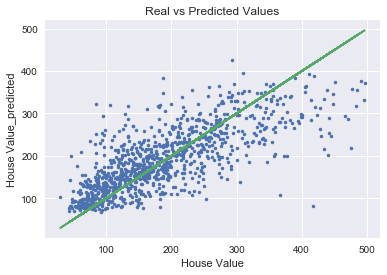

In [52]:
from sklearn.metrics import mean_absolute_error

mlp_m_best.fit(x_train, y_train)
x_test = std_sc.fit_transform( X_test)
y_pred = mlp_m_best.predict(x_test)

print("MAE: %.3f" % -mean_absolute_error(y_test, y_pred))

plt.title('Real vs Predicted Values')
plt.xlabel('House Value')
plt.ylabel('House Value_predicted')
_ = plt.plot(y_test, y_pred, '.', y_test, y_test, '-')

**_Discuss here your conclusions about the MLPs you have obtained_**

We have obtained an MLP model with a reasonable error metrics, the model has 17 layer each layer has 17 neurons, and as activation function we have chosen *relu*, as we can see the predict values fit well with the real ones, but in greater  values, the model tend to fail more.

## Support Vector Regression

### Buildng the train and test datasets

In [53]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

### SVR training times

We are going to work with a Gaussian SVR model, which may take time to train.
Before starting CV, train individual SVRs likely to overfit mesauring times to get a handle on the times involved.

In [54]:

# scale data
x = std_sc.fit_transform(X_train)
num_patterns, dim = x.shape
svc_m = SVR(C=1., gamma=1/dim, kernel='rbf', shrinking=False, tol=1.e-6)

t_0 = time.time()
svc_m.fit(x, y_train)
print("train_time:", time.time() - t_0)


train_time: 0.5788276195526123


In [55]:
X_test.shape

(1000, 3)

In [56]:
dim

3

### CV estimation of `C`, `gamma`, `epsilon`

A reasonable idea is to work with validation sets with more or less the same size than the test set. 
Use again the sklearn `ShuffleSplit` method to work with 5 folds with train-validation splits with sizes 3000-1000.

Decide also on the proper ranges of  `C`, `gamma`, `epsilon` to be explored.

**_Write HERE your CV parameter choices_**

In [57]:
 list( y_train.std() * np.array([2.**k for k in range(-15, -8)]) )

[0.0029877563039789525,
 0.005975512607957905,
 0.01195102521591581,
 0.02390205043183162,
 0.04780410086366324,
 0.09560820172732648,
 0.19121640345465296]

In [58]:
# writhe the code to perform GridSearchCV and to save the CV results in a pkl file 
#            but 
# COMMENT OUT THE GRID SEARCH FIT CALL AND THE PKL FILE SAVING

# use the names of the GridSearchCV object and of the pickle file shown below
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=10)
        
l_C       = [7.**k for k in range(1, 3) ]
l_gamma   = list( np.array([2.**k for k in range(0, 5)]) / dim )

l_epsilon = list( y_train.std() * np.array([9.**k for k in range(-5, 1)]))
kernel= [ 'rbf']
parameters = {'C': l_C, 'gamma': l_gamma, 'epsilon':l_epsilon}

print("num_hyperparams", len(l_C) * len(l_gamma)*len(l_epsilon)*len(kernel))


svc_m = SVR(kernel='rbf', shrinking=False, tol=1.e-5)

C_gamma_epsilon_search = GridSearchCV(svc_m, param_grid=parameters, 
                              cv=cv, 
                              scoring='neg_mean_absolute_error', n_jobs=4,
                              return_train_score=True, verbose=10)

t_0 = time.time()
#C_gamma_search.fit(x, y)

C_gamma_epsilon_search.fit(x,y_train)
print("grid_search_time:", time.time() - t_0)
f_pkl = open("svr_C_gamma_epsilon_cv_search_results.pkl", 'wb') 
pickle.dump(C_gamma_epsilon_search, f_pkl)
f_pkl.close()

num_hyperparams 60
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   23.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   26.6s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   36.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   40.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   52.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Do

grid_search_time: 116.37053942680359


### Analysis of CV results

**_Recover grid search from pickle file and analyze best parameters_**

best_C: 49.0 	best_gamma: 0.6666666666666666 	best_epsilon: 10.878088729864702


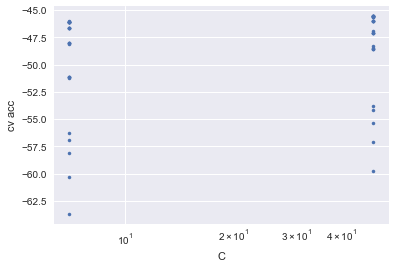

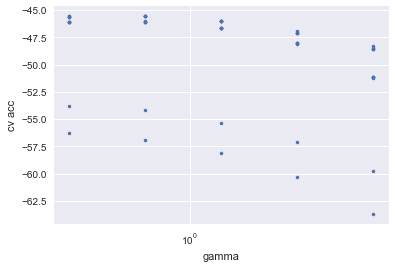

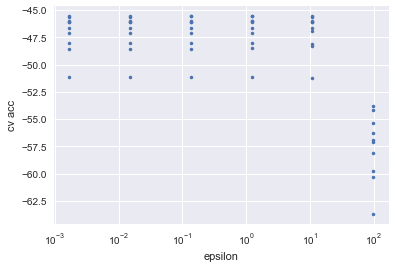

In [59]:
f_pkl = open('svr_C_gamma_epsilon_cv_search_results.pkl', mode='rb')
C_gamma_search = pickle.load(f_pkl)
f_pkl.close()

print("best_C:", C_gamma_search.best_params_['C'], "\tbest_gamma:", C_gamma_search.best_params_['gamma'], "\tbest_epsilon:", C_gamma_search.best_params_['epsilon'])

df_C_gamma_search = pd.DataFrame.from_dict(C_gamma_search.cv_results_)

plt.xlabel('C')
plt.ylabel('cv acc')
plt.xscale('log')
#plt.ylim(0.786, 0.788)
_ = plt.plot( df_C_gamma_search['param_C'], df_C_gamma_search['mean_test_score'], '.')
plt.show()

plt.xlabel('gamma')
plt.ylabel('cv acc')
plt.xscale('log')
#plt.ylim(0.786, 0.788)
_ = plt.plot( df_C_gamma_search['param_gamma'], df_C_gamma_search['mean_test_score'], '.')
plt.show()

plt.xlabel('epsilon')
plt.ylabel('cv acc')
plt.xscale('log')
#plt.ylim(0.786, 0.788)
_ = plt.plot( df_C_gamma_search['param_epsilon'], df_C_gamma_search['mean_test_score'], '.')
plt.show()

In [60]:
df_C_gamma_search.sort_values(by='mean_test_score', ascending=False)[['param_C', 'param_gamma', 'param_epsilon', 'mean_test_score']][ : 10]

,param_C,param_gamma,param_epsilon,mean_test_score
51,49,0.666667,10.8781,-45.572727
36,49,0.666667,0.0149219,-45.577950
31,49,0.666667,0.00165799,-45.577983
41,49,0.666667,0.134297,-45.579146
46,49,0.666667,1.20868,-45.579811
45,49,0.333333,1.20868,-45.581771
40,49,0.333333,0.134297,-45.599643
35,49,0.333333,0.0149219,-45.602669
30,49,0.333333,0.00165799,-45.603399
50,49,0.333333,10.8781,-45.604557


**_Discuss here the adequacy of your CV results_**

High values of γ (low bandwidth) induce more complex models, fortunately we have a low gamma, a low C too, and an epsilon that could allow us some soft separation.

### Analysis of Best SVR

Train and test the best SVR and analyze its errors.

In [61]:
best_C = C_gamma_search.best_params_['C']
best_gamma = C_gamma_search.best_params_['gamma']
best_eps = C_gamma_search.best_params_['epsilon']
svc_m = C_gamma_search.best_estimator_

svc_m.fit(x, y_train)

print("num_svs_per_class:", svc_m.n_support_)
print("dual_coefs:       ", svc_m.dual_coef_)
print("intercep:         ", svc_m.intercept_)

num_svs_per_class: [ -230 13780]
dual_coefs:        [[ 49.  49. -49. ...  49. -49. -49.]]
intercep:          [199.39286684]


In [62]:
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix


cv_rms_best = cross_val_score(svc_m, x, y_train, cv=cv, scoring='neg_mean_absolute_error')
print("\ncv mean accuracy: %.3f" % (cv_rms_best.mean()))



cv mean accuracy: -45.573


In [63]:
x = std_sc.fit_transform( X_train)
x1 = std_sc.fit_transform(X_test)
svr_m =  C_gamma_search.best_estimator_

svr_m.fit(x, y_train)


SVR(C=49.0, cache_size=200, coef0=0.0, degree=3, epsilon=10.878088729864702,
  gamma=0.6666666666666666, kernel='rbf', max_iter=-1, shrinking=False,
  tol=1e-05, verbose=False)

In [64]:
y_pred = (svr_m.predict(x1))


from sklearn import metrics
print(-metrics.mean_absolute_error((y_test), y_pred))


-46.517139026968856


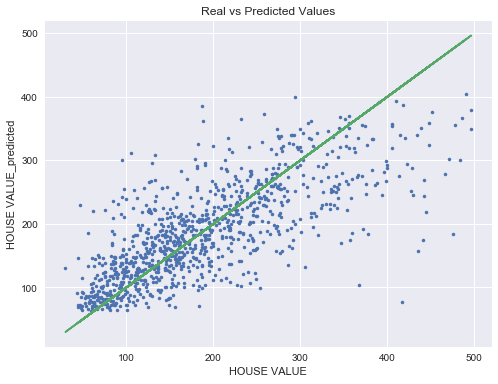

In [65]:
plt.figure( figsize=(8,6))
plt.title('Real vs Predicted Values')
plt.xlabel('HOUSE VALUE')
plt.ylabel('HOUSE VALUE_predicted')
_ = plt.plot(y_test, y_pred, '.', y_test, y_test, '-')

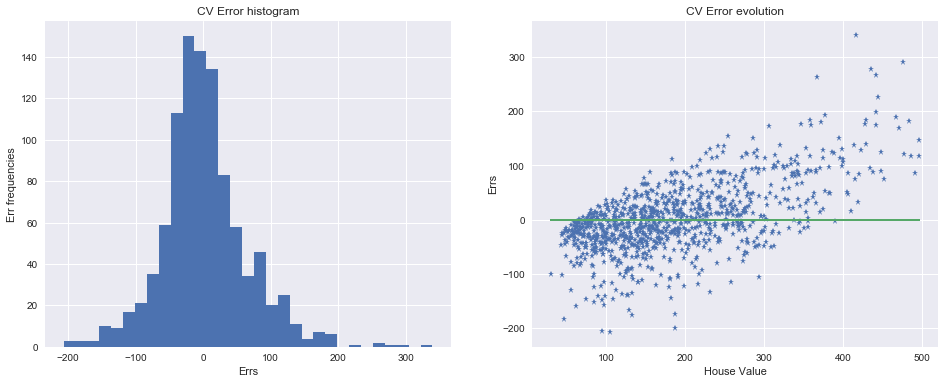

In [66]:
err = y_test - y_pred

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("House Value")
plt.ylabel("Errs")
_ = plt.plot(y_test, err, '*', y_test, 0.*y_test, '-')

plt.show()

According to the plot of errors, we can see that follow a normal distribution, and again our model fail more in greater house values

## Final conclusions

**_write here your ideas/conclusions_**

* Overall impresions onyour models:
 * **Both model are good enough for the data we have. A Support Vector Machine (SVM) is a very powerful and versatile Machine Learning model, and MLP is a powerful model too.
in SVR Unfortunately, the performance can be quite sensitive to the selection of the regularization and kernel parameters**

* Which one is best and why?
 * **The best models is the SVR as we saw in the accuracy metric and (in this case) it has a lower training excution time, MLP on other hand could take too much time for training (it depend on the architecture), also we can say that the harder model for tuning is SVR because has more hyperparameters**
* Any ideas on how to improve them?
 * **To improve our models we can add some more data, but the execution time could be a limitation, mainly on SVR (because we saw that the time complexity increase adding more data), also we can explore some other tecnhiques for hyperparameters search like bayesian optimization**
  * **Make some aditional treatment of data**

## Reference

- [Class Notes and github of Prof: José Dorronsoro](https://github.com/joseDorronsoro/) 
- [oreilly hands on machine learning with scikit learn and tensorflow](http://shop.oreilly.com/product/0636920052289.do) 